In [1]:
#!pip install transformers[torch]
#!pip install accelerate -U
#!pip install datasets

In [ ]:
access_token = ""

In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, default_data_collator, EarlyStoppingCallback, IntervalStrategy
#from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Import all needed metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
id = 0

In [6]:
if torch.cuda.is_available():
    GPU = torch.cuda.get_device_name(id)
    print(f"PyTorch available GPU: {GPU}")
else:
    print("GPU not available")

PyTorch available GPU: Tesla V100-SXM2-16GB


In [7]:
torch.cuda.device_count()

1

In [8]:
device = torch.device(f"cuda:{id}" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [9]:
# device = torch.device("cpu")
# print(f'Device: {device}')

In [10]:
dataset = pd.read_csv('/content/drive/MyDrive/H.IAAC/datasets/balanced_output.csv')

In [11]:
dataset

,level_0,index,Unnamed: 0,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language
0,2812,4087,4087,7c7a7fe6-f187-48c6-823a-70ae734b04a3,"the app runs a little slow at times, but nothi...",5,5,26.23.0.100,2023-12-09 10:57:59,NaN,NaN,26.23.0.100,2,145,en
1,17483,24985,24985,c76ab0e8-50f0-48ec-a920-9de9329299fa,You do realize there is more than just apple S...,3,0,22.19.0.100,2022-05-06 03:05:51,NaN,NaN,22.19.0.100,1,379,en
2,7525,10956,10956,5cd981cf-c9be-45ee-b0e3-92af3d7c2a12,"Easy to use if you know what you want, simple ...",5,2,26.21.0.100,2023-11-01 11:15:01,NaN,NaN,26.21.0.100,2,208,en
3,7019,10263,10263,74daab50-f012-4d3d-a880-9a3f0e4fd159,Work ok but frozen on loading and searching as...,3,1,26.21.0.100,2023-11-05 12:08:47,NaN,NaN,26.21.0.100,1,52,en
4,8328,12432,12432,af3b1dfc-9982-49d2-ab96-d06f2b9ae9a6,easy shopping and fast delivery,5,0,26.19.4.100,2023-10-10 17:42:38,NaN,NaN,26.19.4.100,2,31,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11626,4226,6159,6159,6eb97318-ab71-4b6c-a7af-d486bc38953a,love it can always find what I need and great ...,5,0,26.20.0.100,2023-11-24 15:20:22,NaN,NaN,26.20.0.100,2,83,en
11627,9673,14414,14414,0e6be9a1-7922-431e-b202-2907cfbaae87,The app is SLOW and not intuitive at all! Sear...,2,0,26.15.0.100,2023-08-09 07:22:09,NaN,NaN,26.15.0.100,0,298,en
11628,3504,5093,5093,37341abd-e64f-4e4e-af5f-1148dfc23a31,Love Amazon if you're not happy with a purchas...,5,1,26.22.0.100,2023-12-01 21:41:25,NaN,NaN,26.22.0.100,2,221,en
11629,15987,22652,22652,6f9ccf0a-bb3d-4490-9b30-a1c5e0e62f18,Less cumbersomely awkward. Improved member con...,3,0,24.5.2.100,2022-08-04 06:18:49,NaN,NaN,24.5.2.100,1,63,en


In [12]:
dataset.shape

(11631, 15)

In [13]:
sentiment_counts_balanced = dataset['sentiment'].value_counts().sort_index()
print(sentiment_counts_balanced)

0    3877
1    3877
2    3877
Name: sentiment, dtype: int64


In [14]:
# Load the pre-trained BERT model and tokenizer
#model_name = "/home/patrick.araujo/llama2/llama/llama-2-7b-hf"
#model_name = "mistralai/Mistral-7B-v0.1"
model_name = "bert-base-uncased"
#model_name = "google-t5/t5-base"
#model_name = "google-t5/t5-small"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, token=access_token)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
# Move model to GPU
model = model.to(device)

In [16]:
# Create train and validation datasets
comments = dataset[['content', 'sentiment']]
train_data, val_data = train_test_split(comments, test_size=0.2, random_state=42)

In [17]:
train_data

,content,sentiment
2191,"It functions, but as I am browsing products I ...",1
5277,Good application but the Voice search doesn't ...,1
11059,App is now incredibly laggy to the point I'm u...,0
5050,I have gotten several nice items,2
4702,Everytime I buy from Amazon it always cancle m...,0
...,...,...
11284,"Used to be fast, but had allowed down a lot in...",1
5191,We absolutely love Amazon! I honestly have fou...,2
5390,Of course ads are what you would expect from a...,1
860,Love it! Amazon is just about the place to get...,2


In [18]:
val_data

,content,sentiment
7323,Works well enough. Looks pretty identical with...,1
5082,It would be nice to have a tracking widget,2
1078,Worked fine until update. Why do companies try...,1
1277,Bring back the old wishlist features.,1
7912,Giving a 2-star option due to new update that ...,1
...,...,...
4429,Amazon get good deal but the problem some deli...,1
5339,So far so good I'm happy with my items,2
11231,Amazon shopping app isn't responding it needs ...,2
3488,It's fine. I prefer the browser experience but...,1


In [19]:
#tokenizer.pad_token = tokenizer.eos_token
#tokenizer.padding_size = 'right'

In [20]:
max_length = 512

In [21]:
def tokenizerFunction(string):
  # Tokenize a list of texts and return a dictionary with the tokenization outputs
  tokens = tokenizer(string, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
  return tokens

train_encodings = train_data['content'].apply(tokenizerFunction)
val_encodings = val_data['content'].apply(tokenizerFunction)

In [22]:
train_encodings

2191     [input_ids, token_type_ids, attention_mask]
5277     [input_ids, token_type_ids, attention_mask]
11059    [input_ids, token_type_ids, attention_mask]
5050     [input_ids, token_type_ids, attention_mask]
4702     [input_ids, token_type_ids, attention_mask]
                            ...                     
11284    [input_ids, token_type_ids, attention_mask]
5191     [input_ids, token_type_ids, attention_mask]
5390     [input_ids, token_type_ids, attention_mask]
860      [input_ids, token_type_ids, attention_mask]
7270     [input_ids, token_type_ids, attention_mask]
Name: content, Length: 9304, dtype: object

In [23]:
val_encodings

7323     [input_ids, token_type_ids, attention_mask]
5082     [input_ids, token_type_ids, attention_mask]
1078     [input_ids, token_type_ids, attention_mask]
1277     [input_ids, token_type_ids, attention_mask]
7912     [input_ids, token_type_ids, attention_mask]
                            ...                     
4429     [input_ids, token_type_ids, attention_mask]
5339     [input_ids, token_type_ids, attention_mask]
11231    [input_ids, token_type_ids, attention_mask]
3488     [input_ids, token_type_ids, attention_mask]
8307     [input_ids, token_type_ids, attention_mask]
Name: content, Length: 2327, dtype: object

In [24]:
def creatingDataframe(encodings):
  indices = encodings.index.to_numpy()

  df = pd.DataFrame(columns=['input_ids', 'attention_mask'])

  # Assuming 'content' is a Series or List containing tuples/lists
  for element in encodings:
    input_ids = element['input_ids'][0].numpy()              # Replace with correct index based on your data structure
    attention_mask = element['attention_mask'][0].numpy()    # Replace with correct index
    df.loc[len(df.index)] = [input_ids, attention_mask]
  df_index = pd.DataFrame(indices, columns=['index'])
  df['index'] = df_index['index']
  return df

# Batch Size

In [25]:
# Define batch size and create data loaders
batch_size = 16  # Adjust as needed

In [26]:
# Create datasets
# Convert labels to tensors
train_dataset = creatingDataframe(train_encodings)
train_labels = train_data['sentiment'].reset_index(name='label')
train_dataset = pd.merge(train_dataset, train_labels, on='index')

val_dataset = creatingDataframe(val_encodings)
val_labels = val_data['sentiment'].reset_index(name='label')
val_dataset = pd.merge(val_dataset, val_labels, on='index')

# train_dataset = SentimentDataset(train_encodings, train_labels)
# val_dataset = SentimentDataset(val_encodings, val_labels)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=default_data_collator)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=default_data_collator)

In [27]:
train_dataset = train_dataset.drop('index', axis=1)
val_dataset = val_dataset.drop('index', axis=1)

In [28]:
train_dataset

,input_ids,attention_mask,label
0,"[101, 2009, 4972, 1010, 2021, 2004, 1045, 2572...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,"[101, 2204, 4646, 2021, 1996, 2376, 3945, 2987...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,"[101, 10439, 2003, 2085, 11757, 2474, 22772, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
3,"[101, 1045, 2031, 5407, 2195, 3835, 5167, 102,...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",2
4,"[101, 2296, 7292, 1045, 4965, 2013, 9733, 2009...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...
9299,"[101, 2109, 2000, 2022, 3435, 1010, 2021, 2018...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
9300,"[101, 2057, 7078, 2293, 9733, 999, 1045, 9826,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
9301,"[101, 1997, 2607, 14997, 2024, 2054, 2017, 205...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
9302,"[101, 2293, 2009, 999, 9733, 2003, 2074, 2055,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [29]:
val_dataset

,input_ids,attention_mask,label
0,"[101, 2573, 2092, 2438, 1012, 3504, 3492, 7235...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,"[101, 2009, 2052, 2022, 3835, 2000, 2031, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",2
2,"[101, 2499, 2986, 2127, 10651, 1012, 2339, 207...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,"[101, 3288, 2067, 1996, 2214, 4299, 9863, 2838...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",1
4,"[101, 3228, 1037, 1016, 1011, 2732, 5724, 2349...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
...,...,...,...
2322,"[101, 9733, 2131, 2204, 3066, 2021, 1996, 3291...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2323,"[101, 2061, 2521, 2061, 2204, 1045, 1005, 1049...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",2
2324,"[101, 9733, 6023, 10439, 3475, 1005, 1056, 141...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",2
2325,"[101, 2009, 1005, 1055, 2986, 1012, 1045, 9544...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1


In [30]:
# Define a custom dataset class
#class CustomDataset(Dataset):
#    def __init__(self, dataframe, data):
#        self._data = data
#
#    def __len__(self):
#        return len(self._data)
#
#    def __getitem__(self, idx):
#        label = self.labels[idx]
#        input_ids = self.input_ids[idx]
#        attention_mask = self.attention_masks[idx]
#        return {
#            'input_ids': torch.tensor(dataframe['input_ids'], dtype=torch.long),
#            'attention_mask': torch.tensor(dataframe['attention_mask'], dtype=torch.long),
#            'labels': torch.tensor(dataframe['label'], dtype=torch.long)
#        }

In [31]:
#train_dataset = CustomDataset(train_dataset, train_data)
#val_dataset = CustomDataset(val_dataset, val_data)

train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

In [32]:
# path = ''
path = '/content/drive/MyDrive/H.IAAC/datasets/'

In [33]:
# Define training arguments with early stopping
training_args = TrainingArguments(
    # Positional arguments:
    # output_dir= path+"./bert-base-uncased_sentiment_model",
    # logging_dir= path+"./logs_b",
    output_dir= "./bert-base-uncased_sentiment_model",
    logging_dir= "./logs_b",


    # Keyword arguments:
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    #eval_steps=250,                         # Adjust as needed
    save_total_limit=2,                     # Adjust as needed. Only last 2 models are saved. Older ones are deleted.
    num_train_epochs=10,                     # Adjust as needed
    save_steps=500,                         # Adjust as needed
    metric_for_best_model="eval_loss",      # Use validation loss for early stopping
    learning_rate= 7e-05,
    warmup_steps=500,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [34]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert logits to predicted labels
    predicted_labels = np.argmax(logits, axis=1)

    metrics = {}
    # Calculate accuracy
    accuracy = accuracy_score(labels, predicted_labels)
    balanced_accuracy = balanced_accuracy_score(labels, predicted_labels)
    metrics['accuracy'] = accuracy
    metrics['balanced_accuracy'] = balanced_accuracy

    # Calculate precision, recall, F1 score, and support for each class
    precision, recall, f1, support = precision_recall_fscore_support(labels, predicted_labels)


    # Create a dictionary to store metrics for each class
    class_metrics = {}
    for i in range(len(precision)):
        class_metrics[f'class_{i}'] = {
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }

    precision_ALL = precision_score(labels, predicted_labels, average='macro')
    recall_ALL = recall_score(labels, predicted_labels, average='macro')
    f1_ALL = f1_score(labels, predicted_labels, average='macro')

    metrics['precision'] = precision_ALL
    metrics['recall'] = recall_ALL
    metrics['f1'] = f1_ALL

    # Print and return the metrics
    for class_name, c_metrics in class_metrics.items():
        metrics[f'{class_name}_precision'] = c_metrics["precision"]
        metrics[f'{class_name}_recall'] = c_metrics["recall"]
        metrics[f'{class_name}_f1'] = c_metrics["f1"]
        metrics[f'{class_name}_support'] = c_metrics["support"]

    return metrics

In [35]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [36]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 0 Support,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 1 Support,Class 2 Precision,Class 2 Recall,Class 2 F1,Class 2 Support
1,0.903900,0.809611,0.599484,0.600102,0.654093,0.600102,0.597968,0.745679,0.385696,0.508418,783,0.435224,0.690860,0.534026,744,0.781377,0.723750,0.751460,800


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 0 Support,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 1 Support,Class 2 Precision,Class 2 Recall,Class 2 F1,Class 2 Support
1,0.903900,0.809611,0.599484,0.600102,0.654093,0.600102,0.597968,0.745679,0.385696,0.508418,783,0.435224,0.690860,0.534026,744,0.781377,0.723750,0.751460,800
2,0.750700,0.783688,0.641599,0.637293,0.634024,0.637293,0.633594,0.625000,0.721584,0.669828,783,0.503125,0.432796,0.465318,744,0.773946,0.757500,0.765635,800
3,0.596100,1.076295,0.618823,0.615727,0.628922,0.615727,0.616157,0.594100,0.745849,0.661382,783,0.470339,0.447581,0.458678,744,0.822327,0.653750,0.728412,800
4,0.398400,1.139941,0.631715,0.629424,0.636291,0.629424,0.632138,0.643411,0.636015,0.639692,783,0.487085,0.532258,0.508671,744,0.778378,0.720000,0.748052,800
5,0.252000,1.554801,0.627847,0.625249,0.631404,0.625249,0.627798,0.639175,0.633461,0.636305,783,0.476961,0.514785,0.495152,744,0.778075,0.727500,0.751938,800


TrainOutput(global_step=2910, training_loss=0.5239780911055627, metrics={'train_runtime': 1494.7143, 'train_samples_per_second': 62.246, 'train_steps_per_second': 3.894, 'total_flos': 1.224003619270656e+16, 'train_loss': 0.5239780911055627, 'epoch': 5.0})

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the trainer to predict labels on the validation dataset
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract the true labels from the validation dataset
true_labels = val_dataset['label']

# Generate the confusion matrix
unique_labels = dataset['sentiment'].unique()
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[565 192  26]
 [271 322 151]
 [ 68 126 606]]


In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)

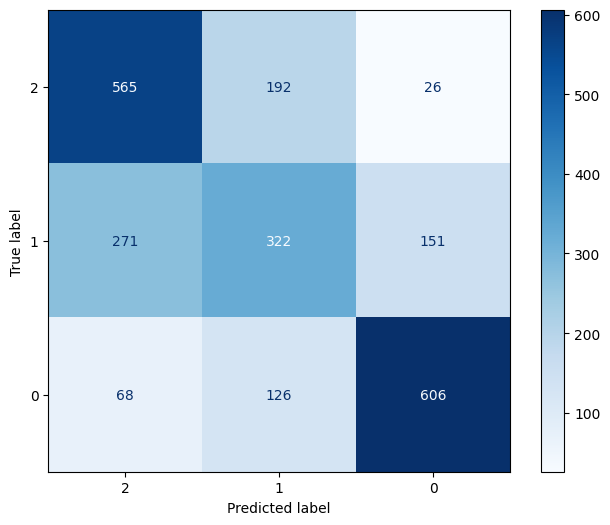

In [46]:
import matplotlib.pyplot as plt
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)

# Save the plot as an image file (e.g., PNG)
plt.savefig('confusion_matrix_bu.png')
plt.savefig('confusion_matrix_bu.svg')

# Optionally, display the plot
plt.show()

In [47]:
# Evaluate the model
results = trainer.evaluate()

In [48]:
results

{'eval_loss': 0.7836876511573792,
 'eval_accuracy': 0.6415986248388483,
 'eval_balanced_accuracy': 0.6372931171809556,
 'eval_precision': 0.6340237867177523,
 'eval_recall': 0.6372931171809556,
 'eval_f1': 0.6335936289293954,
 'eval_class_0_precision': 0.625,
 'eval_class_0_recall': 0.7215836526181354,
 'eval_class_0_f1': 0.6698280972139894,
 'eval_class_0_support': 783,
 'eval_class_1_precision': 0.503125,
 'eval_class_1_recall': 0.4327956989247312,
 'eval_class_1_f1': 0.4653179190751445,
 'eval_class_1_support': 744,
 'eval_class_2_precision': 0.7739463601532567,
 'eval_class_2_recall': 0.7575,
 'eval_class_2_f1': 0.7656348704990524,
 'eval_class_2_support': 800,
 'eval_runtime': 23.2636,
 'eval_samples_per_second': 100.028,
 'eval_steps_per_second': 6.276,
 'epoch': 5.0}

In [49]:
output_file_path = 'bert-base-uncased_sentiment_model'
destination = path+output_file_path

# Save the model
model.save_pretrained(destination)
model.save_pretrained(output_file_path)